#### 1. Import relevant modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
import seaborn as sns

#### 2. Create linear regression with torch

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, num_of_features, lr):
        super(LinearRegression, self).__init__()
        self.linear_layer = nn.Linear(num_of_features, 1)

        self.lr = lr
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)  

    def forward(self, x):
        return self.linear_layer(x)

    def make_step(self, X, y):
        loss = self.criterion(self.forward(X), y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()


#### 3. make learn and video for training.

In [7]:
class Model:
        def __init__(self, X_numpy, y_numpy, model, epochs=50, batch_size=None):
            self.X_numpy = X_numpy
            self.y_numpy = y_numpy

            self.epochs = epochs
            self.batch_size = len(y_numpy) if batch_size is None else batch_size
            self.text = 'GD' if self.batch_size >= len(y_numpy) else f'SGD (batch = {self.batch_size})'

            self.model = model

            self.prev_params = []
            self.losses = []

            self.y_min = min(y_numpy) - 0.1 * (max(y_numpy) - min(y_numpy))
            self.y_max = max(y_numpy) + 0.1 * (max(y_numpy) - min(y_numpy))

            self.graphs = min(4, X_numpy.shape[1])
            self.axes_dims = int(np.ceil(np.sqrt(self.graphs)))
            self.fig, self.ax = plt.subplots(self.axes_dims, self.axes_dims, figsize=(16, 10))


        def plot_data(self, fig_size=(10, 6)):
            plt.plot(self.X_numpy, self.y_numpy, 'o')
            plt.xlabel('x' ,fontsize=14 ,fontweight="bold")
            plt.ylabel('y',fontsize=14 ,fontweight="bold")
            plt.title('Data',fontsize=14 ,fontweight="bold")
            plt.grid()

        def take_batch(self):
            idx = np.random.choice(list(range(len(self.y_numpy))), size=self.batch_size, replace=False)
            X_batch = np.array([self.X_numpy[i] for i in idx])
            y_batch = np.array([self.y_numpy[i] for i in idx])
            return X_batch, y_batch

        def clear_axes(self):
            for i in range(self.axes_dims):
                for j in range(self.axes_dims):
                    self.ax[i, j].set_visible(False)

        def fit_update(self, frame):
            self.clear_axes()
            data = []

            if self.batch_size < len(self.y_numpy):
                X, y = self.take_batch()
            else:
                X, y = self.X_numpy, self.y_numpy

            for dim in range(self.graphs):
                i, j = dim // 2, dim % 2
                self.ax[i, j].clear()
                self.ax[i, j].set_visible(True)
                self.ax[i, j].set_xlabel(f'x_{dim + 1}' ,fontsize=16 ,fontweight="bold")
                self.ax[i, j].set_ylabel('y' ,fontsize=16 ,fontweight="bold")
                X_min_lim = min(self.X_numpy[:, dim]) - 0.1 * (max(self.X_numpy[:, dim]) - min(self.X_numpy[:, dim]))
                X_max_lim = max(self.X_numpy[:, dim]) + 0.1 * (max(self.X_numpy[:, dim]) - min(self.X_numpy[:, dim])) 
                self.ax[i, j].set_xlim(X_min_lim, X_max_lim)
                self.ax[i, j].set_ylim(self.y_min, self.y_max)
                self.ax[i, j].grid()

                input = np.zeros_like(self.X_numpy)
                input[:, dim] = self.X_numpy[:, dim]
                input = torch.from_numpy(input.astype(np.float32))
                predicted = self.model.forward(input).detach().numpy()

                line, = self.ax[i, j].plot(self.X_numpy[:, dim], self.y_numpy, 'ko', ms=6)
                data.append(line)

                line, = self.ax[i, j].plot(self.X_numpy[:, dim], predicted, 'b', lw=3)
                data.append(line)

                if self.batch_size < len(self.y_numpy):
                    line, = self.ax[i, j].plot(X[:, dim], y, 'ro', ms=10, fillstyle='none')
                    data.append(line)
            
            X = torch.from_numpy(X.astype(np.float32))
            y = torch.from_numpy(y.astype(np.float32))
            y = y.view(y.shape[0], 1)

            curr_loss = self.model.make_step(X, y)
            self.losses.append(curr_loss)
            plt.suptitle(f'{self.text}\n' \
                         f'epoch : {frame + 1}\n' \
                         f'loss : {(curr_loss / self.X_numpy.shape[0]):.4f}', fontsize=16 , fontweight="bold")
            return data

        def make_fit_video(self):
            anim = FuncAnimation(self.fig, self.fit_update, frames=list(range(self.epochs + 1)), interval=120, blit=True)
            video = anim.to_html5_video()
            html = display.HTML(video)
            display.display(html)
            plt.close()
            return self.model

        def print_log(self):
            for i, data in enumerate(self.losses):
                print(f'epoch : {i} \n' \
                      f'loss : {data[1]:.4f} \n')

        def plot_loss(self, fig_size=(10, 6)):
            if len(self.losses):
                plt.figure(figsize=fig_size)
                plt.plot(np.linspace(start=0, stop=len(self.losses), num=len(self.losses)), self.losses, lw=3)
                plt.xlabel('epoch' ,fontsize=14 ,fontweight="bold")
                plt.ylabel('Loss',fontsize=14 ,fontweight="bold")
                plt.title('Loss',fontsize=14 ,fontweight="bold")
                plt.grid()

#### 4. run function and plot results

In [8]:
X_numpy, y_numpy = datasets.make_regression(n_samples=140, n_features=5, noise=120)


my_model = LinearRegression(num_of_features=X_numpy.shape[1], lr=0.2)

Model = Model(X_numpy, y_numpy, my_model, epochs=12, batch_size=60)
model = Model.make_fit_video()

#### 5. Load bs data

In [ ]:
def load_data():
    bc = datasets.load_breast_cancer()
    X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, test_size=0.2, random_state=1234)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    X_train = torch.from_numpy(X_train.astype(np.float32))
    X_test = torch.from_numpy(X_test.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))
    y_test = torch.from_numpy(y_test.astype(np.float32))

    y_train = y_train.view(y_train.shape[0], 1)
    y_test = y_test.view(y_test.shape[0], 1)

    return X_train, y_train, X_test, y_test

#### 6. Create logistioc regression

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, X_train, y_train, X_test, y_test, epochs=50, lr=0.01):
        super(LogisticRegression, self).__init__()
        self.linear_layer = nn.Linear(X_train.shape[1], 1)
        
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.epochs = epochs
        self.lr = lr
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.losses = []


    def forward(self, x):
        return torch.sigmoid(self.linear_layer(x))

    def make_step(self):
        loss = self.criterion(self.forward(self.X_train), self.y_train)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()
    
    def fit(self):
        space = int(np.log10(self.epochs)) + 1
        print(space)
        for ep in range(self.epochs):
            curr_loss = self.make_step()
            self.losses.append(curr_loss)
            if (ep + 1) % 10 == 0:
                print(f'epoch : {ep + 1:<{space}}, loss : {curr_loss:.4f}')
        print('\n')

    def evaluate(self):
        if len(self.y_test):
            with torch.no_grad():
                y_predicted_cls = self.forward(self.X_test).round()
                print(f'results \n' \
                    f'accuracy  : {100 * accuracy_score(self.y_test, y_predicted_cls).item():.2f} %\n' \
                    f'precision : {100 * precision_score(self.y_test, y_predicted_cls).item():.2f} %\n' \
                    f'recall    : {100 * recall_score(self.y_test, y_predicted_cls).item():.2f} %\n' \
                    f'f1 score  : {100 * f1_score(self.y_test, y_predicted_cls).item():.2f} %' )
        self.predictions = y_predicted_cls

    def plot_results(self, fig_size=(24, 12)):
            f_beta = []
            for beta in np.linspace(start=0, stop=5, num=200):
                f_beta.append(fbeta_score(self.y_test, self.predictions, beta=beta))

            f1_score = fbeta_score(self.y_test, self.predictions, beta=1)
            conf_matrix = confusion_matrix(self.y_test, self.predictions, labels=[0, 1])
            fig, ax = plt.subplots(1, 2, figsize=fig_size)

            ax[0].plot(np.linspace(start=0, stop=5, num=200), f_beta, lw=5, label=r'$F_{\beta}$')

            ax[0].plot(1, f1_score, 'o', color='k', ms=8)
            ax[0].text(1, f1_score*1.004, f'f1 score = {f1_score:.2f}', fontsize=12)

            ax[0].set_xlabel(r'$\beta$', fontsize=14)
            ax[0].set_ylabel(r'$F_{\beta}, \;\; C_a$', fontsize=14)
            ax[0].set_title(r'$F_{\beta}$ score', fontsize=16)
            ax[0].grid()

            group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
            group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
            group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
            labels = np.asarray([f"{v1} : {v2}\n\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]).reshape(2,2)
            sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 16}, ax=ax[1])
            ax[1].set_title(f'Confusion Matrix for Logistic Classifier\n', fontsize=16);
            ax[1].set_xlabel('Predicted Values\n', fontsize=20)
            ax[1].set_ylabel('Actual Values\n', fontsize=20);
            ax[1].xaxis.set_ticklabels(['False','True'])
            ax[1].yaxis.set_ticklabels(['False','True'])
            ax[1].tick_params(axis='both', labelsize=20)
            plt.show()

#### 7. run and plot results

3
epoch : 10 , loss : 0.2374
epoch : 20 , loss : 0.1760
epoch : 30 , loss : 0.1480
epoch : 40 , loss : 0.1312
epoch : 50 , loss : 0.1197
epoch : 60 , loss : 0.1112
epoch : 70 , loss : 0.1046
epoch : 80 , loss : 0.0994
epoch : 90 , loss : 0.0950
epoch : 100, loss : 0.0913
epoch : 110, loss : 0.0881
epoch : 120, loss : 0.0853
epoch : 130, loss : 0.0828
epoch : 140, loss : 0.0806
epoch : 150, loss : 0.0786
epoch : 160, loss : 0.0768
epoch : 170, loss : 0.0752
epoch : 180, loss : 0.0737
epoch : 190, loss : 0.0723
epoch : 200, loss : 0.0710
epoch : 210, loss : 0.0698
epoch : 220, loss : 0.0686
epoch : 230, loss : 0.0676
epoch : 240, loss : 0.0666
epoch : 250, loss : 0.0657
epoch : 260, loss : 0.0648
epoch : 270, loss : 0.0640
epoch : 280, loss : 0.0632
epoch : 290, loss : 0.0624
epoch : 300, loss : 0.0617
epoch : 310, loss : 0.0610
epoch : 320, loss : 0.0604
epoch : 330, loss : 0.0597
epoch : 340, loss : 0.0591
epoch : 350, loss : 0.0586
epoch : 360, loss : 0.0580
epoch : 370, loss : 0.0575

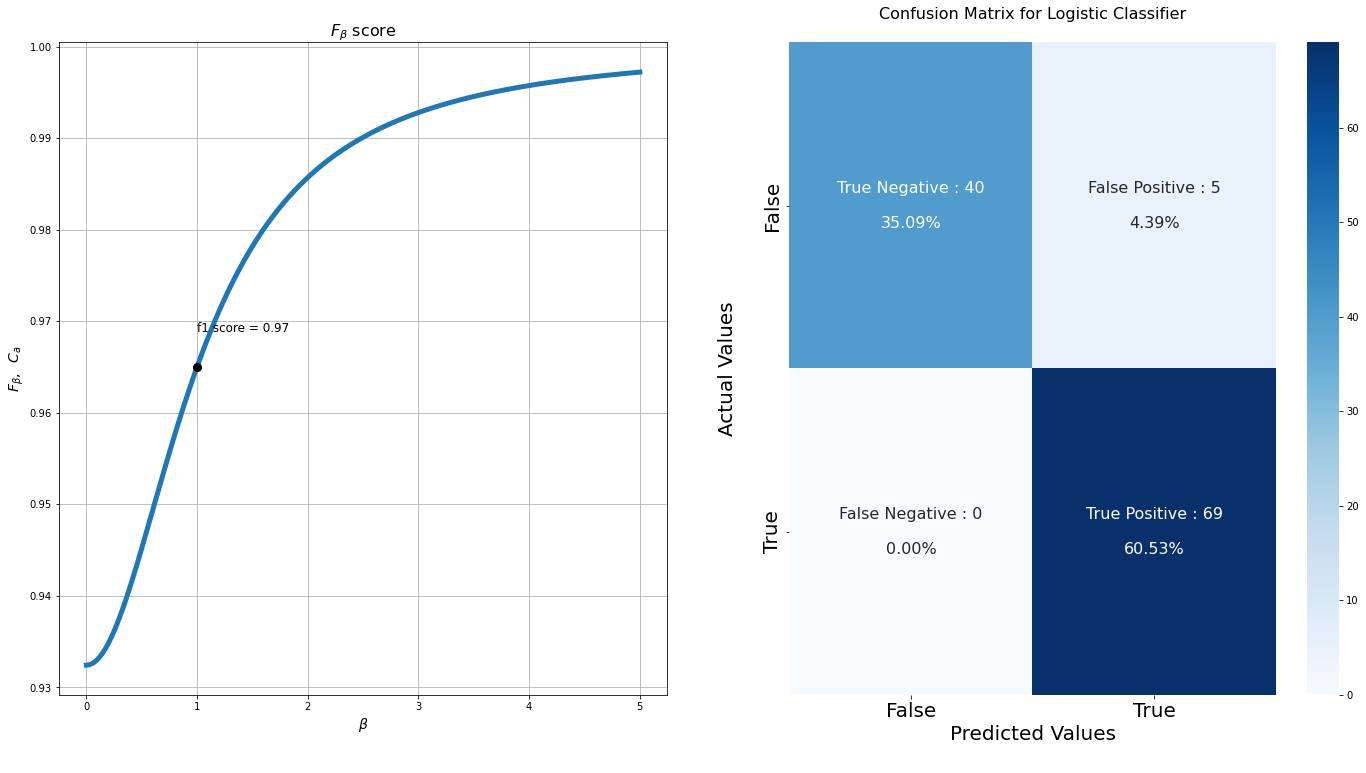

In [9]:
my_model = LogisticRegression(*load_data(), epochs=500, lr=0.1)
my_model.fit()
my_model.evaluate()
my_model.plot_results()